<a href="https://colab.research.google.com/github/Tomoki-Hoshino/report/blob/main/report3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aggregate expected lifetime utility with pension -3.649782030856345


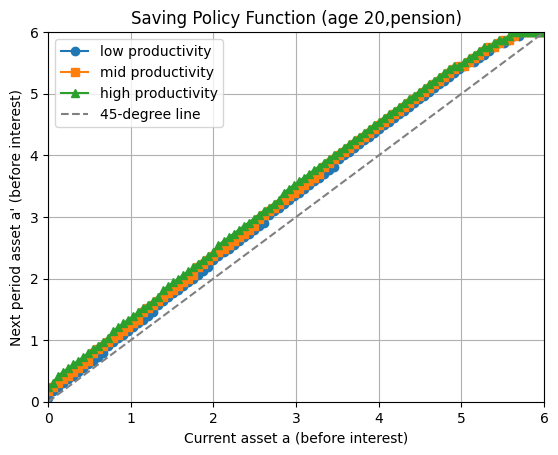

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def util(cons,gamma):
  return max(cons, 0.0001)**(1.0-gamma)/(1.0-gamma)

# parameters
gamma = 2.0
beta = 0.985**20
r = 1.025**20-1.0
jj = 60
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1361],
    [0.0021, 0.2528, 0.7451]
])
mu_1 = np.array([1.0/NL,1.0/NL,1.0/NL])

mu_2 = np.zeros(NL)

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il,ilp]*mu_1[il]

# grids
a_l = 0.0
a_u = 6.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((jj, NA, NL))
iaplus = np.zeros((jj, NA, NL), dtype=int)
aplus = np.zeros((jj, NA, NL))
c = np.zeros((jj, NA, NL))

tax = 0.3
middle_age = range(20, 40)
tax_rate = 0.3
tax_revenue = 0.0
for ij in middle_age:
  for il in range(NL):
    for ia in range(NA):
      tax_revenue += tax_rate * l[il] * mu_2[il]

tax_total = tax_revenue * len(middle_age)
tax_return = tax_total * (1 + r)
old_age = range(40, 60)
old_period = len(old_age)
pension = tax_return / old_period

# period jj
for ia in range(NA):
    for il in range(NL):
        income = pension  # 労働所得ゼロ、年金のみ
        cons = income + (1.0 + r) * a[ia]
        v[jj-1, ia, il] = util(cons, gamma)
        aplus[jj-1, ia, il] = 0.0
        c[jj-1, ia, il] = cons

# backward induction from jj-1 to 1
for ij in range(jj-2, -1, -1):
  for il in range(NL):
      for ia in range(NA):
          reward = np.zeros(NA)
          for iap in range(NA):

              EV = 0.0
              for ilp in range(NL): #期待値を取る
                  EV += prob[il,ilp]*v[ij+1,iap,ilp] #ilpが変動する

              if ij in middle_age:
                    income = (1 - tax_rate) * l[il]
              elif ij in old_age:
                    income = pension
              else:
                    income = l[il]

              cons = income + (1.0 + r) * a[ia] - a[iap]
              reward[iap] = util(cons, gamma) + beta * EV

          iaplus[ij, ia, il] = np.argmax(reward) #max
          aplus[ij, ia, il] = a[iaplus[ij, ia, il]]
          c[ij, ia, il] = l[il]+ (1.0+r)*a[ia] - a[iaplus[ij, ia, il]]
          v[ij, ia, il] = reward[iaplus[ij, ia, il]]

#4
ia0 = 0

avg_lifetime_utility = 0.0
for il in range(NL):
    avg_lifetime_utility += mu_1[il] * v[0, ia0, il]

print("Aggregate expected lifetime utility with pension", avg_lifetime_utility)

plt.figure()
plt.plot(a, aplus[0, :, 0], marker='o', label="low productivity")
plt.plot(a, aplus[0, :, 1], marker='s', label="mid productivity")
plt.plot(a, aplus[0, :, 2], marker='^', label="high productivity")
plt.plot(a, a, linestyle='--', color='gray', label="45-degree line")  # 参考線

plt.title("Saving Policy Function (age 20,pension)")
plt.xlabel("Current asset a (before interest)")
plt.ylabel("Next period asset a' (before interest)")
plt.ylim(a_l, a_u)
plt.xlim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()